In [3]:
import torch
from torch import tensor, matmul, FloatTensor
import numpy as np
import matplotlib.pyplot as plt

$\text{Input Domain}: L_\infty$

$$
\psi : \left( \begin{array}{c}x \\ y \\ \end{array} \right)=
\left( \begin{array}{c}x_0 \\ y_0 \\ \end{array} \right)
+\epsilon_1\left( \begin{array}{c} \eta \\ 0 \\ \end{array} \right)
+\epsilon_2 \left( \begin{array}{c}0 \\ \eta \\ \end{array} \right)
$$

$\forall\,i,\,-1\leq\epsilon_i\leq1$

Affine transform

$$
\left(
\begin{array}{cc}
 w_{1,1} & w_{1,2} \\
 w_{2,1} & w_{2,2} \\
\end{array}
\right).\left(
\begin{array}{ccc}
 x_0 & \eta  & 0 \\
 y_0 & 0 & \eta  \\
\end{array}
\right)+\left(
\begin{array}{c}
 b_1 & 0 & 0 \\
 b_2 & 0 & 0\\
\end{array}
\right)
$$

In [4]:
def box(x):
    radius = torch.sum(torch.abs(x[1:]))
    return x[0] - radius, x[0] + radius

$$
ReLU^{\#}(x)=
\lambda  x+ \frac{1}{2} \left(\epsilon _{\text{new}}+1\right)\begin{cases}
 -l \lambda  & \lambda >\frac{u}{u-l} \\
 u (1-\lambda ) & \text{Otherwise} \\
\end{cases}
$$

In [5]:
def relu_layer_transformer(layer, lambdas):
    boxes =  [box(n) for n in layer]
    _, epsilon_id = layer.shape
    for i, (l, u), lmb in zip(range(len(layer)), boxes, lambdas):
        if u <= 0:
            for val in layer[i]:
                val = 0
        elif l < 0:
            layer = torch.nn.ConstantPad2d((0, 1),0)(layer)  
            layer[i] *= lmb
            
            if lmb >= u/(u-1):
                layer[i][epsilon_id] = -l * lmb / 2
            else:
                layer[i][epsilon_id] = u * (1 - lmb)

            layer[i][0] += layer[i][epsilon_id]
            epsilon_id += 1
            
    return layer

def add_bias(layer, bias):
    #A probably worse approach is to pad right and matrix add
    #return layer + torch.nn.ConstantPad2d((0, layer.shape[1] - 1),0)(b)
    for n, b in zip(layer, bias):
        n[0] += b[0]
    return layer

In [8]:
def optimize(attempts, steps_per_attempt):
    loss_history = np.empty((attempts,steps_per_attempt))
    for attempt in range(attempts):
        lambdas = torch.rand((2,2), requires_grad=True)
        for step in range(steps_per_attempt):
            layer = tensor([[.1,-.1,.1],[-.2,.1,-.1]])

            layer = relu_layer_transformer(layer, lambdas[0])

            w = torch.tensor([[-1, 1],[2, -1]], dtype=torch.float)
            b = torch.tensor([[1],[2]], dtype=torch.float)
            layer = add_bias(matmul(w , layer), b)
            layer = relu_layer_transformer(layer, lambdas[1])

            loss = torch.sum(torch.abs(layer[1] - layer[0]))
            loss_history[attempt][step] = loss
            loss.backward(retain_graph=True)
            if lambdas.grad is not None:
                lambdas = torch.clamp(lambdas - .005 * lambdas.grad, 0, 1).clone().detach().requires_grad_(True)
    return loss_history

Optimizing $\vec{\lambda}$ for $100$ steps starting from $5$ different points

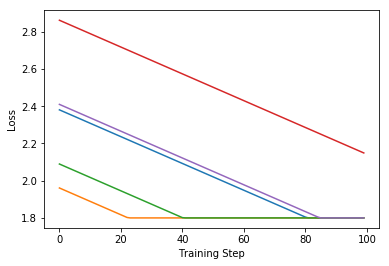

In [11]:
plt.plot(np.transpose(optimize(5,100)));
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.show()

Optimizing for $1$ step starting from $1000$ different starting points. This is equivalent to random guessing for $\lambda\ldots$

Interestingly the distribution is completely uniform. Why would a non linear transformation of uniform random varibales be uniform?? If this doesnt break down for larger networks then random sampling is much more optimal then gradient descent.

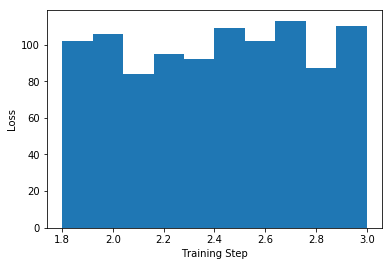

In [323]:
plt.hist(optimize(1000,1).flatten());
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.show()